In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np 
import pandas as pd 
import os
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.models import resnet as model_res
import warnings
warnings.filterwarnings('ignore')
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tqdm import tqdm
# Any results you write to the current directory are saved as output.

In [2]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
torch.backends.cudnn.enabled = False

In [33]:
n_classes = 10
N_EPOCHS = 20
BATCH_SIZE = 256
IMG_DIM = 28
random_seed = 42
torch.manual_seed(random_seed)
torch.backends.cudnn.enabled = False
# Gets the GPU if there is one, otherwise the cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [13]:
# load in data to train/test with
dir_data = '/kaggle/input/Kannada-MNIST'
dir_train = dir_data +'/train.csv'
dir_test = dir_data + '/test.csv'
alternate_test = dir_data + '/Dig-MNIST.csv'

df_train = pd.read_csv(dir_train)
df_test = pd.read_csv(dir_test)
df_alternate_test = pd.read_csv(alternate_test)


In [14]:
# drop training label from training data
target = df_train['label']
df_train.drop('label', axis=1, inplace=True)

# drop id column as uselss
df_test.drop('id', axis=1, inplace=True)

# drop label from alternate test data
alternate_test_label = df_alternate_test['label']
df_alternate_test.drop('label', axis=1, inplace=True)


In [15]:
# random train and test split on the training data.
# alternate_test can be used as a holdout test to evaluate the model.
X_train, X_test, y_train, y_test = train_test_split(df_train, target, stratify=target, random_state=42, test_size=0.1)


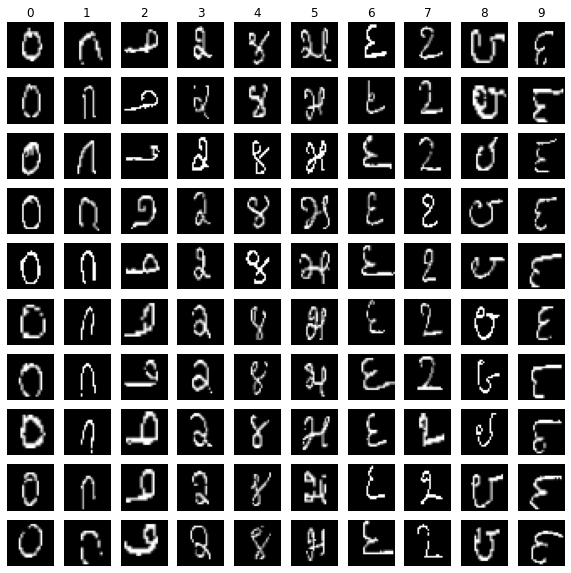

In [24]:
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

# I know these for loops look weird, but this way num_i is only computed once for each class
for i in range(10): # Column by column
    num_i = X_train[y_train == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

In [18]:
class KannadaDataClass(Dataset):
    def __init__(self, images, labels, transform, classes):
        """
        instantiate KannadaData class with class artifacts
        """
        self.X = images
        self.y = labels
        self.tranform = transform
        self.classes = classes
        
    def __len__(self):
        """
        mandatory function
        """
        return len(self.X)
    
    def __getitem__(self, idx=None):
        """
        will return label in softmax format [0,0,0,1,0,...]
        reshape image data to (28,28,1)
        return both image and label.
        """
        img = np.array(self.X.iloc[idx,:], dtype='uint8').reshape((IMG_DIM,IMG_DIM,1))
        if self.y is not None:
            y = np.zeros(self.classes, dtype='float32')
            y[self.y.iloc[idx]] = 1
            return img, y
        else:
            return img

In [19]:
# Put some augmentation on training data using pytorch torchvision.transforms

train_transform = transforms.Compose([
    transforms.Resize([IMG_DIM,IMG_DIM]),
    #transforms.ToPILImage(),
    transforms.RandomAffine(degrees=5, translate=(0.1, 0.1)),
    transforms.ToTensor()
])

# test data is not augmented, kept as it is.
test_transform = transforms.Compose([
    transforms.Resize([IMG_DIM,IMG_DIM]),
    #transforms.ToPILImage(),
    transforms.ToTensor()
])

In [20]:
# create torch datasets for all datasets for easier path to training.
train_dataset = KannadaDataClass(images=X_train, labels=y_train, transform=train_transform, classes=10)
test_dataset = KannadaDataClass(images=X_test, labels=y_test, transform=test_transform, classes=10)
final_result_test_dataset = KannadaDataClass(images=X_test, labels=None, transform=test_transform, classes=10)
alternate_test_dataset = KannadaDataClass(images=df_alternate_test, labels=alternate_test_label, transform=test_transform, classes=10)

In [21]:

# Defining the data generators for producing batches of data
# these dataLoaders are useful for training and evaluation due to how they return data
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
final_result_loader = DataLoader(dataset=final_result_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
alternate_test_loader = DataLoader(dataset=alternate_test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [22]:
class Net(nn.Module):
    def __init__(self):
        """
        initialize net class attributes 
            including conv layers,
            fully connected layers/dense layers
            dropout
        """
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.fc1 = nn.Linear(3200, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        """
        define CNN network architecture
        Quite a general network following CNN development principles
            of using relu, max pooling, dropout etc.
        """
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


In [27]:
model = Net()
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [28]:
def criterion(input, target, size_average=True):
    """
    Categorical cross-entropy with logits input and one-hot target
    """
    l = -(target * torch.log(F.softmax(input, dim=1) + 1e-10)).sum(1)
    if size_average:
        l = l.mean()
    else:
        l = l.sum()
    return l

In [29]:
def train(epoch, model, train_loader, device, optimizer, train_loss):
    """
    function to train the model using gradient descent and back propogation
    """
    model.train()
    # function used to train the model
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        # start of each batch zero our gradient
        optimizer.zero_grad()
        data = data.permute(0, 3, 1, 2).float()
        output = model(data)
        loss = criterion(output, target)
        # calculate our loss for each batch
        loss.backward()
        # back propogate the error/loss through the network
        optimizer.step()
        
        if (batch_idx + 1) % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLR: {:.6f}\tLoss: {:.6f}'.format(
                epoch, (batch_idx + 1) * len(data), len(train_loader.dataset),
                100. * (batch_idx + 1) / len(train_loader),
                optimizer.state_dict()['param_groups'][0]['lr'],
                loss.data))
    train_loss.append(loss.data.cpu().numpy())


In [30]:
def evaluate(model, test_loader, alternate_test_loader, device, test_loss, test_accuracy, alternate_test_loss, alternate_test_accuracy):
    """
    function to test model on test loss data
    and on the alternate test data

    """
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)

            data = data.permute(0, 3, 1, 2).float()
            output = model(data)

            loss += criterion(output, target, size_average=False).data

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.max(1, keepdim=True)[1].data.view_as(pred)).cpu().sum().numpy()
    
    loss /= len(test_loader.dataset)
    accuracy = correct / len(test_loader.dataset)
    
    test_loss.append(loss.cpu().numpy())
    test_accuracy.append(accuracy)

    print('test loss: {:.4f}, test accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(test_loader.dataset),
        100. * accuracy))     

    correct = 0
    loss = 0
    with torch.no_grad():
        for data, target in alternate_test_loader:
            data = data.to(device)
            target = target.to(device)
            # permutation required to change order of dimensions in data variable
            # the input channel should be in the second dimension in pytorch
            data = data.permute(0, 3, 1, 2).float()
            output = model(data)

            loss += criterion(output, target, size_average=False).data

            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.max(1, keepdim=True)[1].data.view_as(pred)).cpu().sum().numpy()
    
    loss /= len(alternate_test_loader.dataset)
    accuracy = correct / len(alternate_test_loader.dataset)
    
    alternate_test_loss.append(loss.cpu().numpy())
    alternate_test_accuracy.append(accuracy)
    
    print('alternate test loss: {:.4f}, alternate test accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(alternate_test_loader.dataset),
        100. * accuracy))     


In [31]:
train_loss = []
test_loss = []
test_accuracy = []
alternate_test_loss = []
alternate_test_accuracy = []

In [ ]:
# run training and evaluation
for epoch in range(N_EPOCHS):
    print('Epoch: '+ str(epoch))
    train(epoch,model,train_loader, device, optimizer, train_loss)
    evaluate(model,test_loader, alternate_test_loader, device, test_loss, test_accuracy, alternate_test_loss, alternate_test_accuracy)


Epoch: 0
Train Epoch: 0 [25600/54000 (47%)]	LR: 0.001000	Loss: 0.128587
Train Epoch: 0 [51200/54000 (95%)]	LR: 0.001000	Loss: 0.014287
test loss: 0.0644, test accuracy: 5876/6000 (97.933%)

alternate test loss: 2.4055, alternate test accuracy: 6635/10240 (64.795%)

Epoch: 1
Train Epoch: 1 [25600/54000 (47%)]	LR: 0.001000	Loss: 0.023864
Train Epoch: 1 [51200/54000 (95%)]	LR: 0.001000	Loss: 0.017224
test loss: 0.0361, test accuracy: 5929/6000 (98.817%)

alternate test loss: 2.1765, alternate test accuracy: 6825/10240 (66.650%)

Epoch: 2
Train Epoch: 2 [25600/54000 (47%)]	LR: 0.001000	Loss: 0.009889
Train Epoch: 2 [51200/54000 (95%)]	LR: 0.001000	Loss: 0.046395
test loss: 0.0215, test accuracy: 5957/6000 (99.283%)

alternate test loss: 2.5410, alternate test accuracy: 6658/10240 (65.020%)

Epoch: 3
Train Epoch: 3 [25600/54000 (47%)]	LR: 0.001000	Loss: 0.016452
Train Epoch: 3 [51200/54000 (95%)]	LR: 0.001000	Loss: 0.014388
test loss: 0.0235, test accuracy: 5949/6000 (99.150%)

alternate te

In [44]:
# model.eval()
# predictions = []

# for data in tqdm(dig_loader):
#     data = data[0].to(device)
#     data = data.permute(0, 3, 1, 2).float()
#     output = model(data).max(dim=1)[1] # argmax
#     predictions += list(output.data.cpu().numpy())

# accuracy_score(dig_label, predictions)

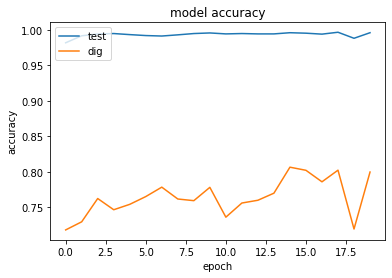

In [56]:
plt.plot(test_accuracy)
plt.plot(alternate_test_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['test', 'dig'], loc='upper left')
plt.show()

# Predict

In [58]:
model.eval()
predictions = []

for data in tqdm(test_loader):
    data = data[0].to(device)
    data = data.permute(0, 3, 1, 2).float()
    output = model(data).max(dim=1)[1] # argmax
    predictions += list(output.data.cpu().numpy())

100%|██████████| 20/20 [00:01<00:00, 18.47it/s]


In [59]:
submission = pd.read_csv('../input/Kannada-MNIST/sample_submission.csv')
submission['label'] = predictions
submission.to_csv('submission.csv', index=False)
submission.head()

,id,label
0,0,3
1,1,0
2,2,2
3,3,6
4,4,7
